# YOLOv11-Small Model Image Classification
Based on Edje Electronics' YOLO Tutorial:
###### https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models

### Split the dataset
Use the functions defined in `../data/data_splitter.py` to randomly split the given dataset into 80% for training and 20% for validation.

In [1]:
import os
import sys
import subprocess
sys.path.append(os.path.abspath(os.path.join('..')))

import data.data_splitter as ds
data_dir = '../data/candy_data_06JAN25'
ds.split_data(data_dir)

Number of image files: 162
Number of annotation files: 162
Images moving to train: 129
Images moving to test: 33


### Configure Model Training and Validation
Use the function defined in `../data/data_yaml_generator.py` to create the YAML data file for training and the `yolo detect {train/predict}` function given by Ultralytics for training and validating the YOLOv11 model on the dataset.

In [3]:
# Create a YAML configuration file for YOLO
import data.data_yaml_generator as dyg
yaml_file = '../data/data.yaml'
classes_file = f'{data_dir}-split/classes.txt'
dyg.create_data_yaml(classes_file, yaml_file)

# Train the model using the YAML configuration file and YOLO model
RETRAIN_MODEL = False
if RETRAIN_MODEL or not os.path.exists('yolo11s.pt'):
    subprocess.run([
        "yolo", "detect", "train",
        f"data={yaml_file}",
        "model=yolo11s.pt",
        "epochs=60",
        "imgsz=640"
    ])

Created config file at ../data/data.yaml


In [4]:
# Evaluate the model
model_path = 'runs/detect/train16/weights/best.pt'
subprocess.run([
    "yolo", "detect", "predict",
    f"model={model_path}",
    f"source={data_dir}-split/test/images",
    "save=True"
])

Ultralytics 8.3.126 🚀 Python-3.12.9 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24077MiB)
YOLO11s summary (fused): 100 layers, 9,417,057 parameters, 0 gradients, 21.3 GFLOPs

image 1/33 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/candy_data_06JAN25-split/test/images/0807ca73-candy_104.jpg: 480x640 1 MMs_regular, 2 airheadss, 1 gummy_worms, 1 snickers, 1 twizzlers, 22.6ms
image 2/33 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/candy_data_06JAN25-split/test/images/09f85b64-candy_19.jpg: 384x640 2 airheadss, 1 gummy_worms, 1 skittles, 1 three_musketeers, 22.4ms
image 3/33 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/candy_data_06JAN25-split/test/images/0d5743ea-candy_110.jpg: 480x640 2 airheadss, 2 gummy_wormss, 1 skittles, 2.1ms
image 4/33 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/candy_data_06JAN25-split/test/images/1600f5b1-candy_9

CompletedProcess(args=['yolo', 'detect', 'predict', 'model=runs/detect/train16/weights/best.pt', 'source=../data/candy_data_06JAN25-split/test/images', 'save=True'], returncode=0)

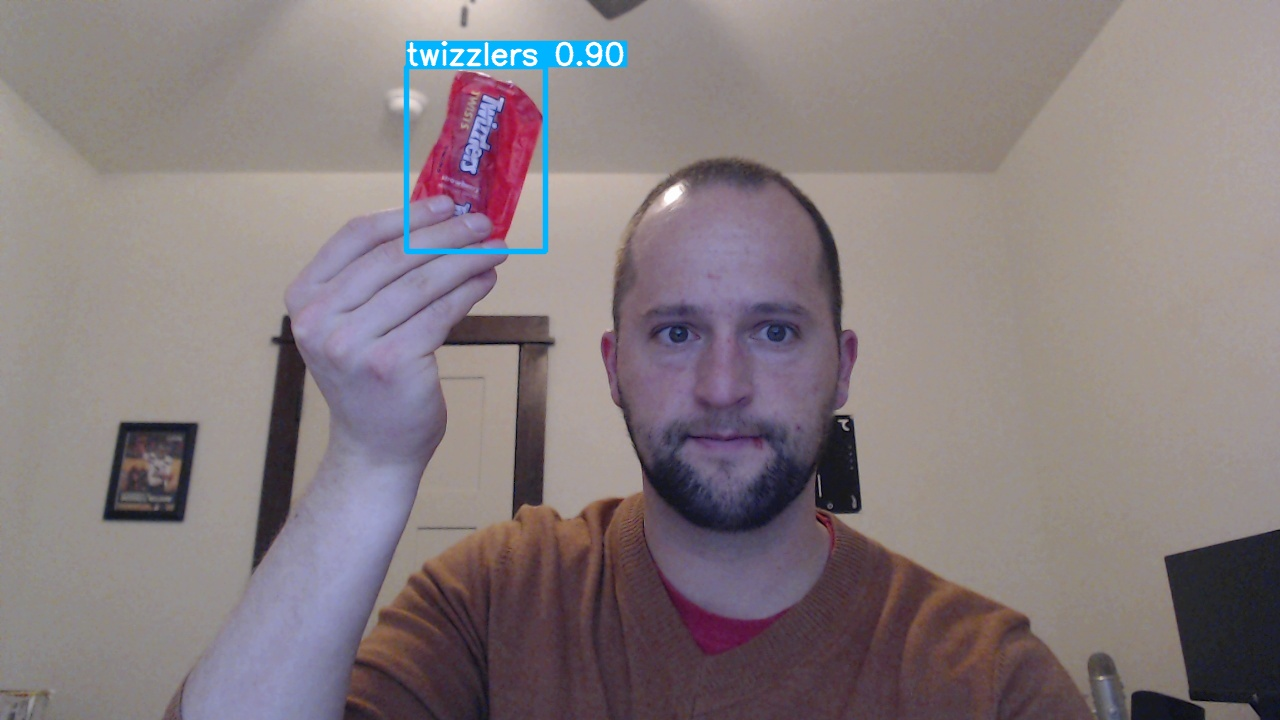

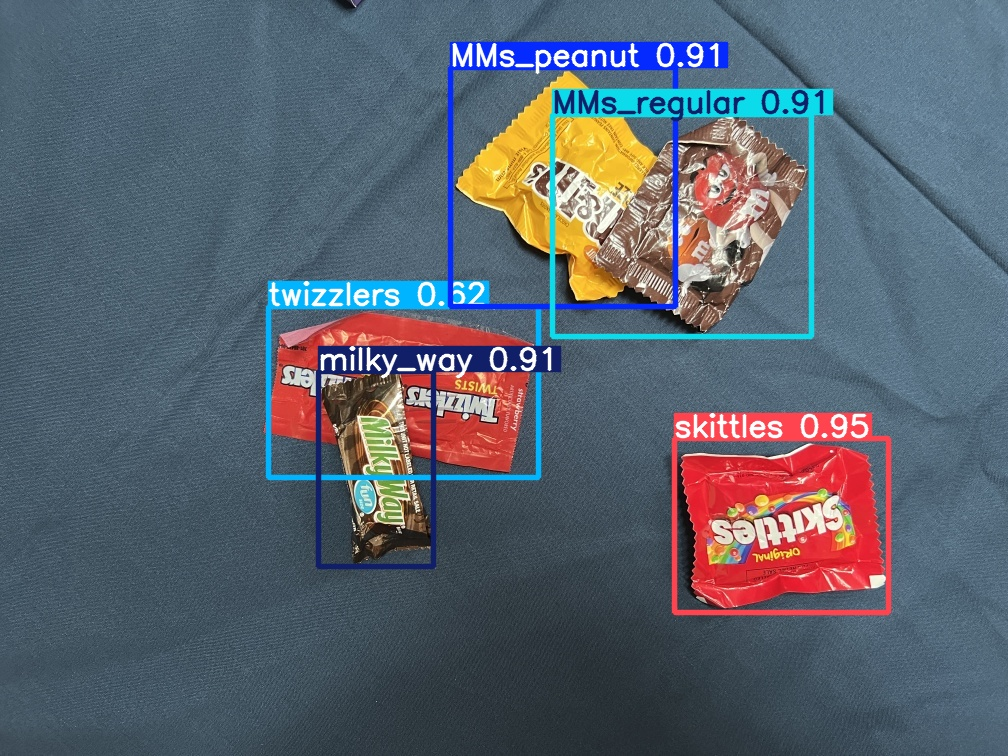

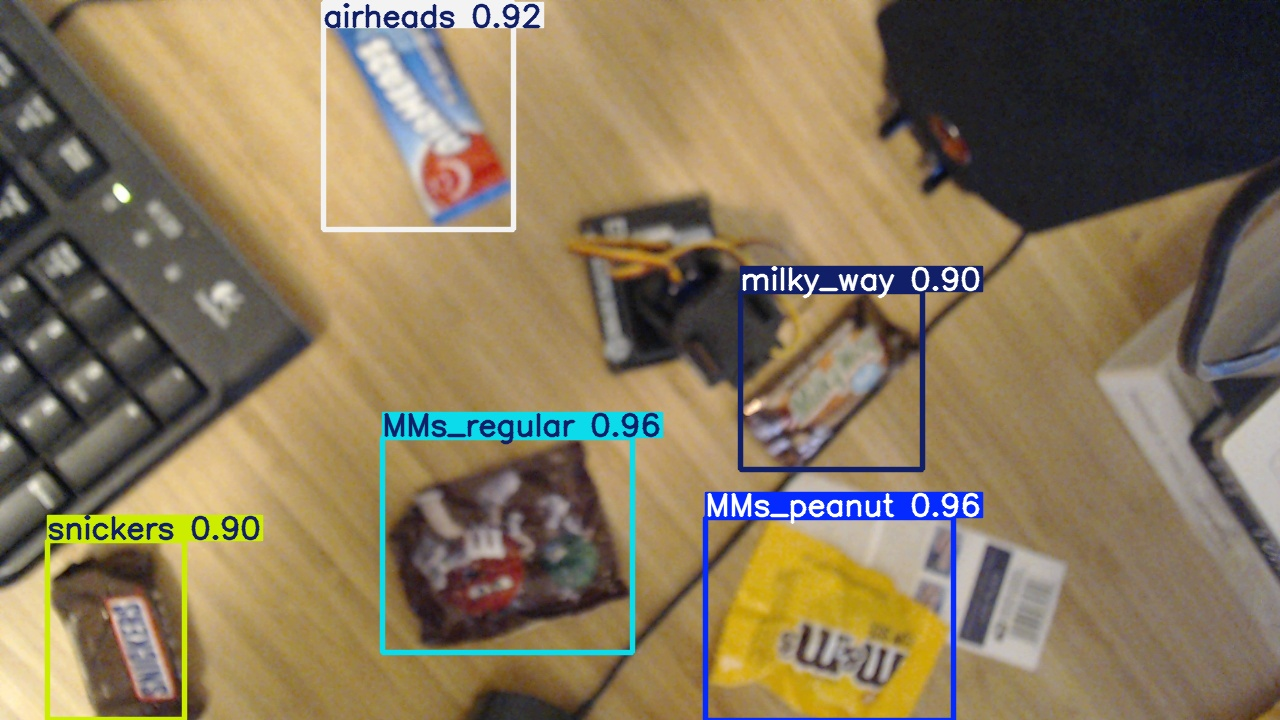

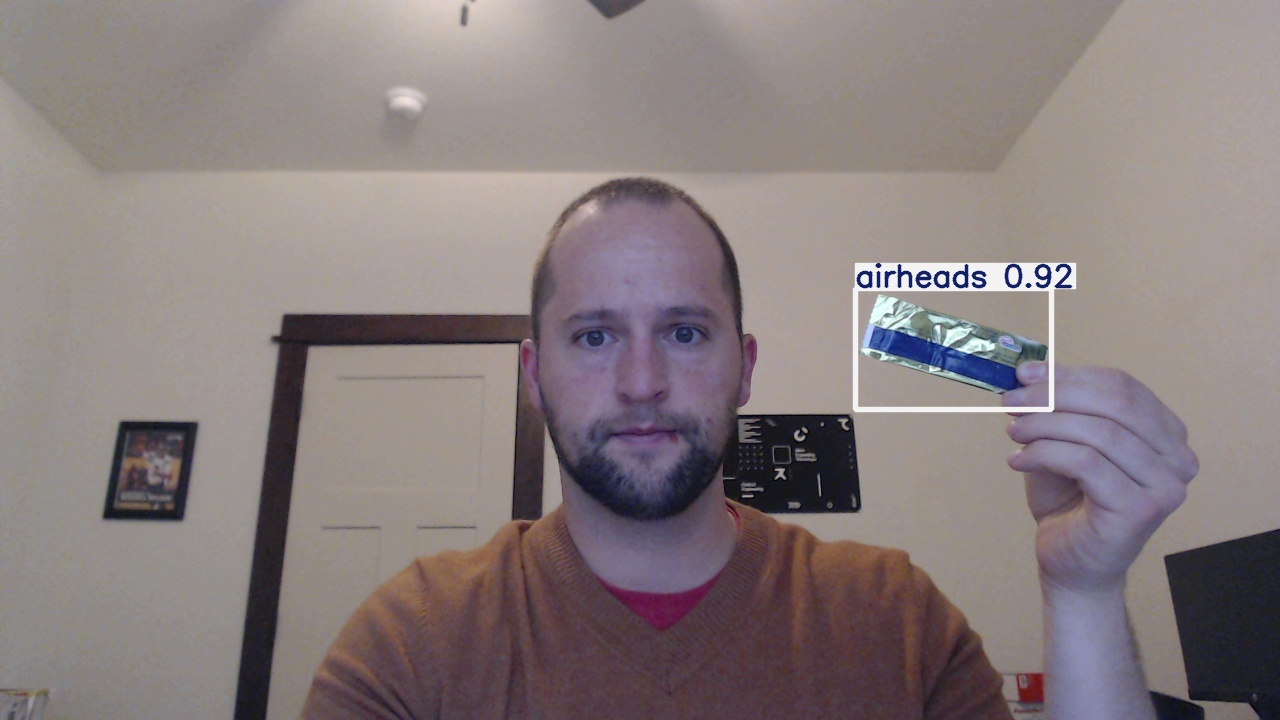

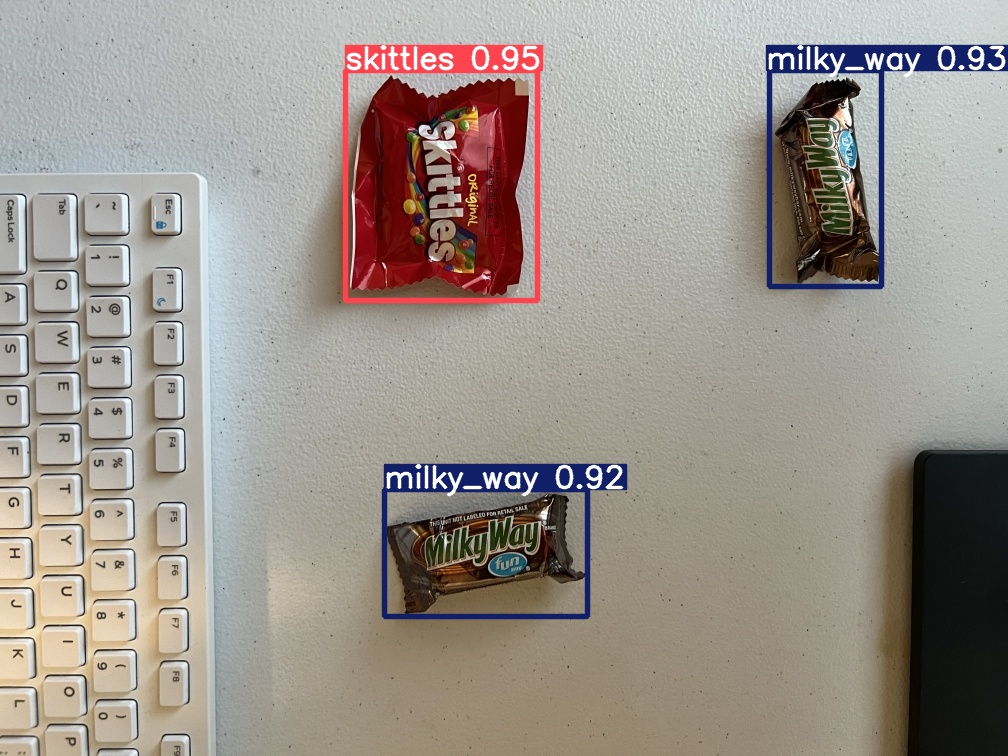

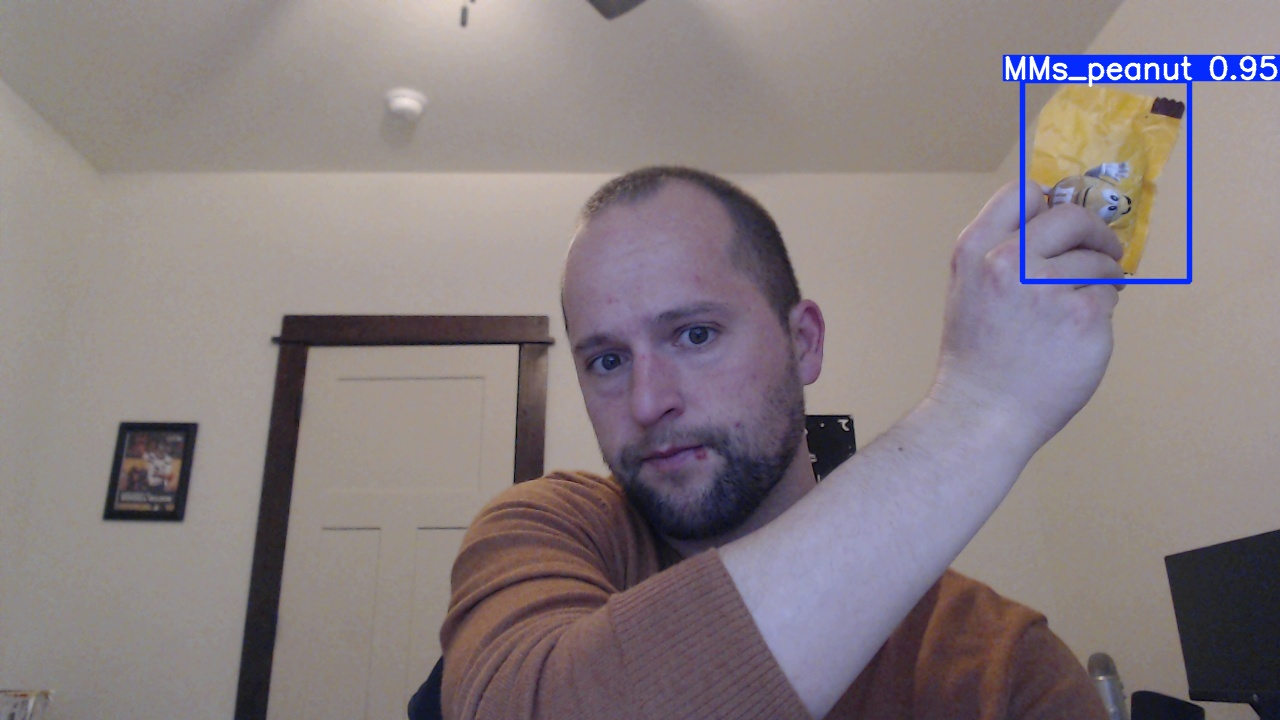

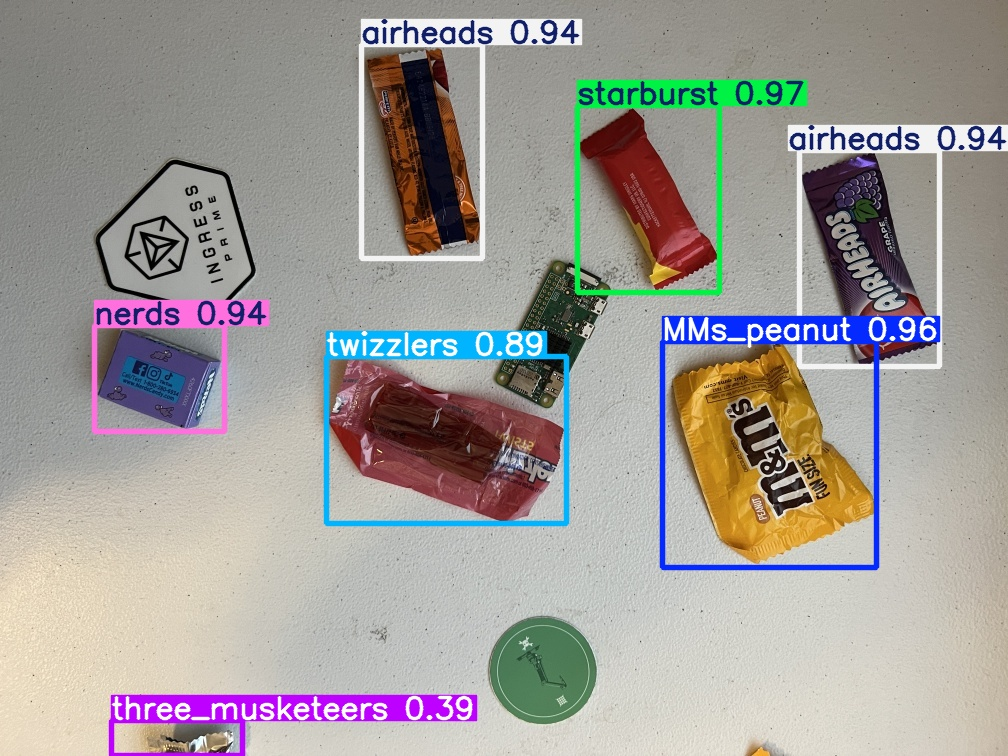

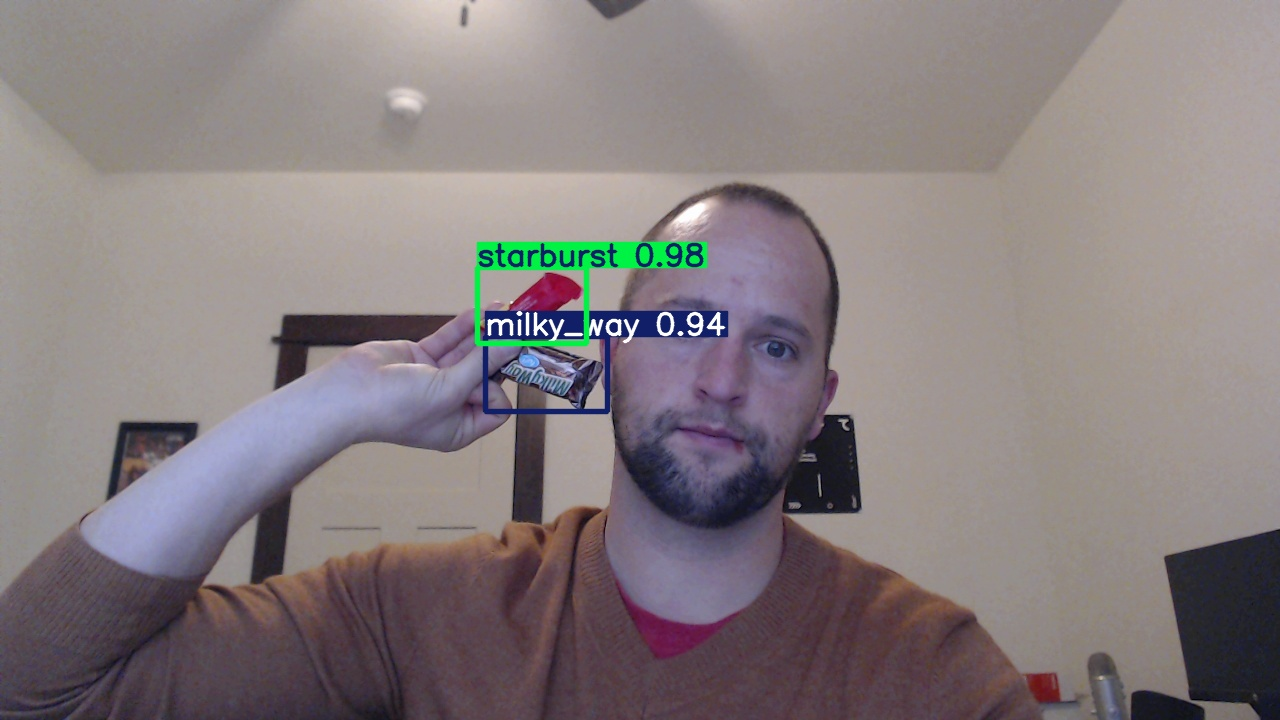

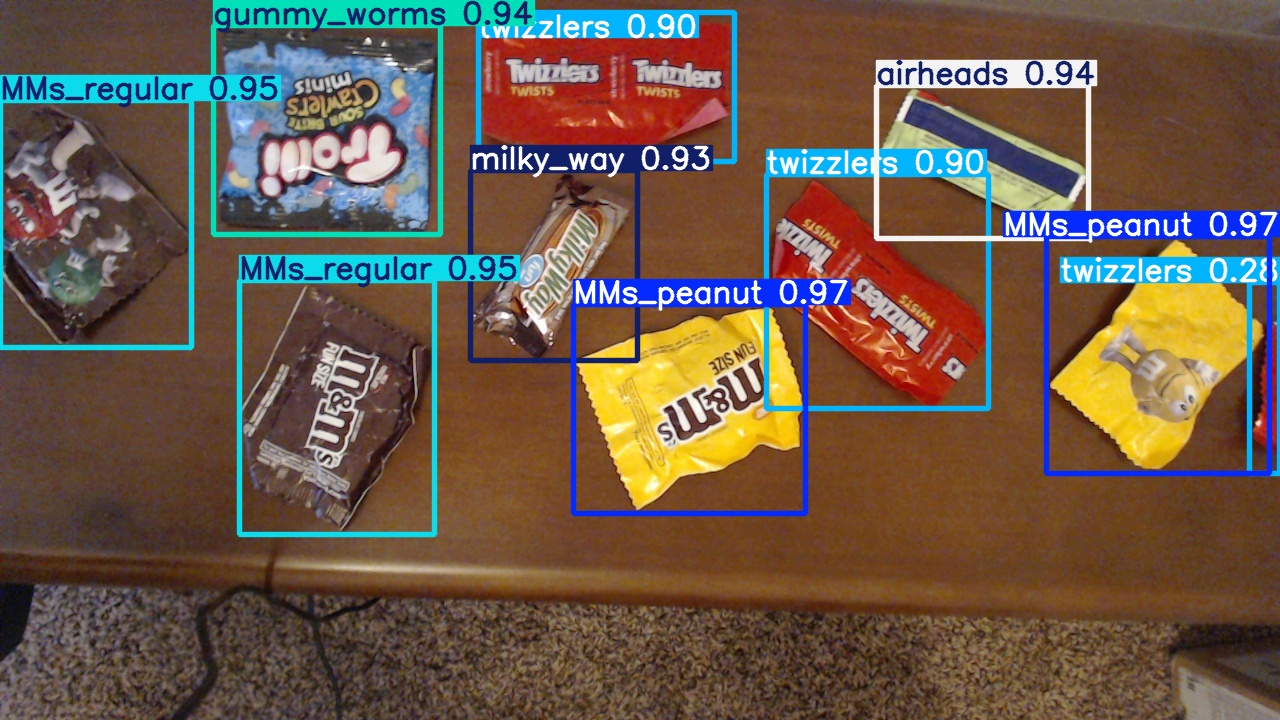

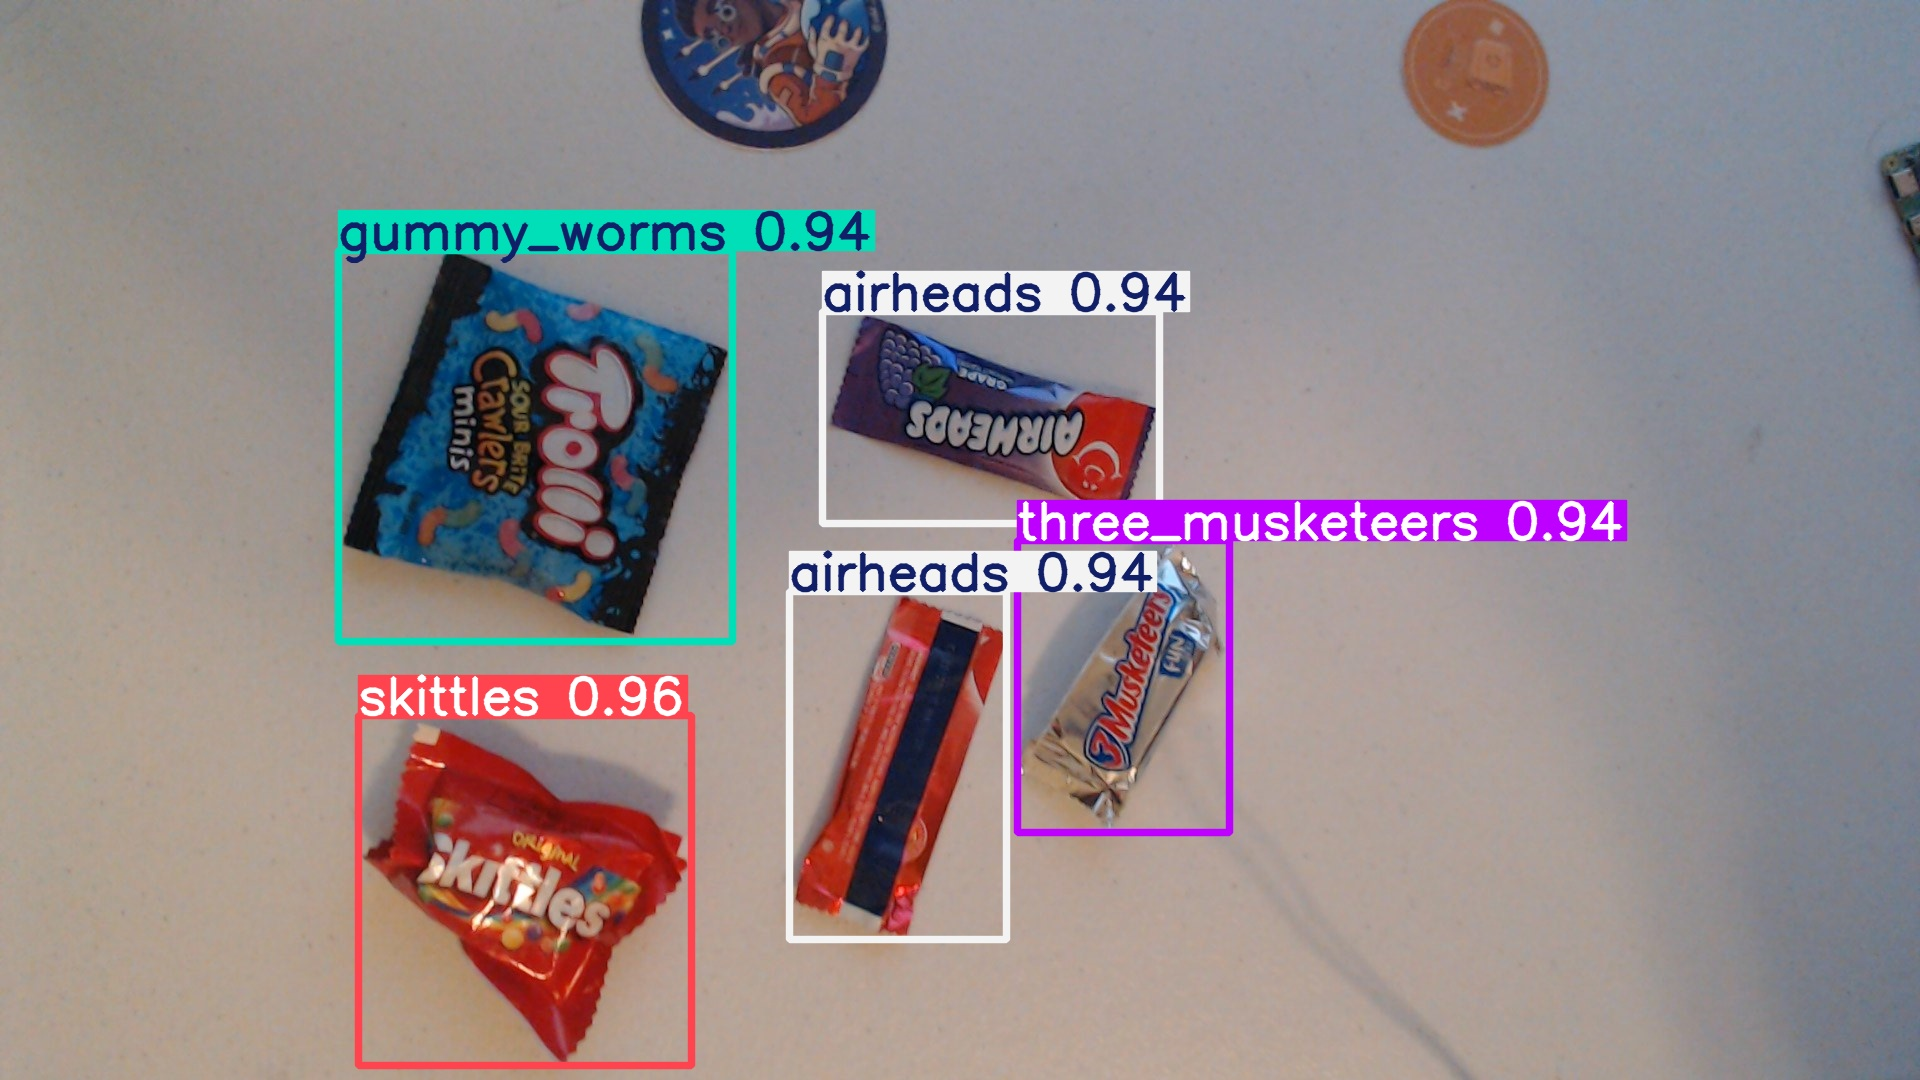

In [19]:
# Display some of the validation results (10 images with label predictions)
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'./runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')

### Inference

In [5]:
import glob
import time
import cv2
import numpy as np
from ultralytics import YOLO

In [7]:
model_path = './runs/detect/train16/weights/best.pt'
img_source = f'{data_dir}-test/testvid.mp4'
# min_thresh = 
user_res = '1280x720'
record = True

In [8]:
if (not os.path.exists(model_path)):
    print('ERROR: Model path is invalid or model was not found. Make sure the model filename was entered correctly.')
    sys.exit(0)
else:
    print('Model found')

Model found


In [9]:
model = YOLO(model_path, task='detect')
labels = model.names

In [10]:
# Parse input to determine if image source is a file, folder, video, or USB camera
img_ext_list = ['.jpg','.JPG','.jpeg','.JPEG','.png','.PNG','.bmp','.BMP']
vid_ext_list = ['.avi','.mov','.mp4','.mkv','.wmv']

In [11]:
if os.path.isdir(img_source):
    source_type = 'folder'
elif os.path.isfile(img_source):
    _, ext = os.path.splitext(img_source)
    if ext in img_ext_list:
        source_type = 'image'
    elif ext in vid_ext_list:
        source_type = 'video'
    else:
        print(f'File extension {ext} is not supported.')
        sys.exit(0)
elif 'usb' in img_source:
    source_type = 'usb'
    usb_idx = int(img_source[3:])
elif 'picamera' in img_source:
    source_type = 'picamera'
    picam_idx = int(img_source[8:])
else:
    print(f'Input {img_source} is invalid. Please try again.')
    sys.exit(0)

print(source_type)

video


In [12]:
# Parse user-specified display resolution
resize = False
if user_res:
    resize = True
    resW, resH = int(user_res.split('x')[0]), int(user_res.split('x')[1])

print(resW, resH)

1280 720


In [26]:
# Check if recording is valid and set up recording
if record:
    if source_type not in ['video','usb']:
        print('Recording only works for video and camera sources. Please try again.')
        sys.exit(0)
    if not user_res:
        print('Please specify resolution to record video at.')
        sys.exit(0)
    
    # Set up recording
    record_name = '../results/demo1.mp4'
    record_fps = 30
    recorder = cv2.VideoWriter(record_name, cv2.VideoWriter_fourcc(*'mp4v'), record_fps, (resW,resH))

In [27]:
# Load or initialize image source
if source_type == 'image':
    imgs_list = [img_source]
elif source_type == 'folder':
    imgs_list = []
    filelist = glob.glob(img_source + '/*')
    for file in filelist:
        _, file_ext = os.path.splitext(file)
        if file_ext in img_ext_list:
            imgs_list.append(file)
elif source_type == 'video' or source_type == 'usb':
    if source_type == 'video': cap_arg = img_source
    elif source_type == 'usb': cap_arg = usb_idx
    cap = cv2.VideoCapture(cap_arg)

    # Set camera or video resolution if specified by user
    if user_res:
        ret = cap.set(3, resW)
        ret = cap.set(4, resH)
elif source_type == 'picamera':
    from picamera2 import Picamera2
    cap = Picamera2()
    cap.configure(cap.create_video_configuration(main={"format": 'RGB888', "size": (resW, resH)}))
    cap.start()

In [28]:
# Set bounding box colors (using the Tableu 10 color scheme)
bbox_colors = [(164,120,87), (68,148,228), (93,97,209), (178,182,133), (88,159,106), 
              (96,202,231), (159,124,168), (169,162,241), (98,118,150), (172,176,184)]

In [29]:
# Initialize control and status variables
avg_frame_rate = 0
frame_rate_buffer = []
fps_avg_len = 200
img_count = 0

In [30]:
# Define the video codec and create a VideoWriter object
output_path = '../results/output_video.mp4'  # Set your desired output path and filename
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Choose codec (e.g., XVID, MJPG)
fps = 20  # Set frames per second (adjust to your needs)

# Create VideoWriter object
recorder = cv2.VideoWriter(output_path, fourcc, fps, (resW, resH))

# Begin inference loop
while True:

    t_start = time.perf_counter()
    # Load frame from image source
    if source_type == 'image' or source_type == 'folder': # If source is image or image folder, load the image using its filename
        if img_count >= len(imgs_list):
            print('All images have been processed. Exiting program.')
            sys.exit(0)
        img_filename = imgs_list[img_count]
        frame = cv2.imread(img_filename)
        img_count = img_count + 1
    
    elif source_type == 'video': # If source is a video, load next frame from video file
        ret, frame = cap.read()
        if not ret:
            print('Reached end of the video file. Exiting program.')
            break
    
    elif source_type == 'usb': # If source is a USB camera, grab frame from camera
        ret, frame = cap.read()
        if (frame is None) or (not ret):
            print('Unable to read frames from the camera. This indicates the camera is disconnected or not working. Exiting program.')
            break

    elif source_type == 'picamera': # If source is a Picamera, grab frames using picamera interface
        frame = cap.capture_array()
        if (frame is None):
            print('Unable to read frames from the Picamera. This indicates the camera is disconnected or not working. Exiting program.')
            break

    # Resize frame to desired display resolution
    if resize == True:
        frame = cv2.resize(frame,(resW,resH))

    # Run inference on frame
    results = model(frame, verbose=False)

    # Extract results
    detections = results[0].boxes

    # Initialize variable for basic object counting example
    object_count = 0

    # Go through each detection and get bbox coords, confidence, and class
    for i in range(len(detections)):

        # Get bounding box coordinates
        # Ultralytics returns results in Tensor format, which have to be converted to a regular Python array
        xyxy_tensor = detections[i].xyxy.cpu() # Detections in Tensor format in CPU memory
        xyxy = xyxy_tensor.numpy().squeeze() # Convert tensors to Numpy array
        xmin, ymin, xmax, ymax = xyxy.astype(int) # Extract individual coordinates and convert to int

        # Get bounding box class ID and name
        classidx = int(detections[i].cls.item())
        classname = labels[classidx]

        # Get bounding box confidence
        conf = detections[i].conf.item()

        # Draw box if confidence threshold is high enough
        if conf > 0.5:

            color = bbox_colors[classidx % 10]
            cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), color, 2)

            label = f'{classname}: {int(conf*100)}%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), color, cv2.FILLED) # Draw white box to put label text in
            cv2.putText(frame, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1) # Draw label text

            # Basic example: count the number of objects in the image
            object_count = object_count + 1

    # Calculate and draw framerate (if using video, USB, or Picamera source)
    if source_type == 'video' or source_type == 'usb' or source_type == 'picamera':
        cv2.putText(frame, f'FPS: {avg_frame_rate:0.2f}', (10,20), cv2.FONT_HERSHEY_SIMPLEX, .7, (0,255,255), 2) # Draw framerate
    
    # # Display detection results
    # cv2.putText(frame, f'Number of objects: {object_count}', (10,40), cv2.FONT_HERSHEY_SIMPLEX, .7, (0,255,255), 2) # Draw total number of detected objects
    # cv2.imshow('YOLO detection results',frame) # Display image
    # if record: recorder.write(frame)

    # If inferencing on individual images, wait for user keypress before moving to next image. Otherwise, wait 5ms before moving to next frame.
    if source_type == 'image' or source_type == 'folder':
        key = cv2.waitKey()
    elif source_type == 'video' or source_type == 'usb' or source_type == 'picamera':
        key = cv2.waitKey(5)
    
    if key == ord('q') or key == ord('Q'): # Press 'q' to quit
        break
    elif key == ord('s') or key == ord('S'): # Press 's' to pause inference
        cv2.waitKey()
    elif key == ord('p') or key == ord('P'): # Press 'p' to save a picture of results on this frame
        cv2.imwrite('capture.png',frame)
    
    # Calculate FPS for this frame
    t_stop = time.perf_counter()
    frame_rate_calc = float(1/(t_stop - t_start))

    # Append FPS result to frame_rate_buffer (for finding average FPS over multiple frames)
    if len(frame_rate_buffer) >= fps_avg_len:
        temp = frame_rate_buffer.pop(0)
        frame_rate_buffer.append(frame_rate_calc)
    else:
        frame_rate_buffer.append(frame_rate_calc)

    # Calculate average FPS for past frames
    avg_frame_rate = np.mean(frame_rate_buffer)

    if record:
        recorder.write(frame)

recorder.release()

Reached end of the video file. Exiting program.


In [31]:
# Clean up
print(f'Average pipeline FPS: {avg_frame_rate:.2f}')
if source_type == 'video' or source_type == 'usb':
    cap.release()
elif source_type == 'picamera':
    cap.stop()
if record: recorder.release()
cv2.destroyAllWindows()

Average pipeline FPS: 287.48
